# Offset-domain Kirchhoff migration of the Volve synthetic data

### Author: M.Ravasi

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import lsqr
from scipy.signal import convolve, filtfilt

from pylops import LinearOperator
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.kirchhoff import Kirchhoff
from pylops.waveeqprocessing.twoway import AcousticWave2D

from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *

In [2]:
def trav_srcrec_to_midoff(trav_srcs, trav_recs, s, r, mid, off):
    noff, nmid = off.size, mid.size
    dmid = mid[1] - mid[0]
    doff = off[1] - off[0]
    trav_mid_off = np.full((nmid, noff, nx * nz), np.nan)
    fold_mid_off = np.zeros((nmid, noff))
    for isrc in range(ns):
        src = s[isrc]
        for irec in range(nr):
            rec = r[irec]
            off_ = src - rec
            mid_ = (src + rec) / 2

            ioff = int((off_ - off[0]) / doff)
            imid = int((mid_ - mid[0]) / dmid)
            if 0 <= imid < nmid and 0 <= ioff < noff:
                trav_mid_off[imid, ioff] = trav_srcs[:, isrc] + trav_recs[:, irec]
                fold_mid_off[imid, ioff] +=1
    return trav_mid_off, fold_mid_off

In [3]:
# Convert data to off-midpoint
def data_srcrec_to_midoff(data, s, r, mid, off, nt):
    noff, nmid = off.size, mid.size
    dmid = mid[1] - mid[0]
    doff = off[1] - off[0]
    data_mid_off = np.zeros((nmid, noff, nt))
    fold_mid_off = np.zeros((nmid, noff))
    for isrc in range(ns):
        src = s[isrc]
        for irec in range(nr):
            rec = r[irec]
            off_ = src - rec
            mid_ = (src + rec) / 2

            ioff = int((off_ - off[0]) / doff)
            imid = int((mid_ - mid[0]) / dmid)
            if 0 <= imid < nmid and 0 <= ioff < noff:
                data_mid_off[imid, ioff] = data[isrc, irec]
                fold_mid_off[imid, ioff] +=1
    return data_mid_off, fold_mid_off

In [4]:
import os
from typing import Optional, Tuple, Union

from pylops.utils.decorators import reshaped
from pylops.utils.typing import DTypeLike, NDArray
from pylops.utils import deps

jit_message = deps.numba_import("the kirchhoff module")

if jit_message is None:
    from numba import jit, prange

    # detect whether to use parallel or not
    numba_threads = int(os.getenv("NUMBA_NUM_THREADS", "1"))
    parallel = True if numba_threads != 1 else False
else:
    prange = range

    
class OffKirchhoff(LinearOperator):
    def __init__(
        self,
        z: NDArray,
        x: NDArray,
        t: NDArray,
        mid: NDArray,
        wav: NDArray,
        wavcenter: int,
        trav: NDArray,
        engine: str = "numpy",
        dtype: DTypeLike = "float64",
        name: str = "K",
    ) -> None:

        self.z, self.x = z, x
        self.t, self.nt = t, t.size
        self.dt = t[1]
        self.nz, self.nx = z.size, x.size
        self.mid, self.nmid = mid, mid.size
        self.trav = trav
        self.cop = Convolve1D((self.nmid, self.nt), h=wav, offset=wavc, axis=1)
        super().__init__(dtype=np.dtype(dtype), dims=(self.nx, self.nz), dimsd=(self.nmid, self.nt), name=name)
        self._register_multiplications(engine)
    
    def _register_multiplications(self, engine: str) -> None:
        if engine not in ["numpy", "numba"]:
            raise KeyError("engine must be numpy or numba")
        if engine == "numba" and jit_message is None:
            # numba
            numba_opts = dict(
                nopython=True, nogil=True, parallel=parallel
            )  # fastmath=True,
            self._kirch_matvec = jit(**numba_opts)(self._trav_matvec)
            self._kirch_rmatvec = jit(**numba_opts)(self._trav_rmatvec)
        else:
            if engine == "numba" and jit_message is not None:
                logging.warning(jit_message)
            self._kirch_matvec = self._trav_matvec
            self._kirch_rmatvec = self._trav_rmatvec
           
    @staticmethod
    def _trav_matvec(x, y, nx, nz, nmid, nt, dt, trav):
        for imid in prange(nmid): # loop over midpoints
            for ix in range(nx): # loop over x coordinate of image point
                for iz in range(nz): # loop over z coordinate of image point
                    if trav[imid, ix, iz] >= 0:
                        tt = trav[imid, ix, iz] / dt
                        itt = int(tt)
                        dtt = tt - itt                    
                        if 0 <= itt < nt - 1:
                            y[imid, itt] += x[ix, iz] * (1 - dtt)
                            y[imid, itt + 1] += x[ix, iz] * dtt
        return y
    
    @staticmethod
    def _trav_rmatvec(x, y, nx, nz, nmid, nt, dt, trav):
        for ix in prange(nx): # loop over x coordinate of image point
            for imid in range(nmid): # loop over midpoints
                for iz in range(nz): # loop over z coordinate of image point
                    if trav[imid, ix, iz] >= 0:
                        tt = trav[imid, ix, iz] / dt
                        itt = int(tt)
                        dtt = tt - itt                    
                        if 0 <= itt < nt - 1:
                            y[ix, iz] += x[imid, itt] * (1 - dtt) +  x[imid, itt + 1] * dtt
        return y
    
    @reshaped
    def _matvec(self, x):
        y = np.zeros((self.nmid, self.nt), dtype=self.dtype)
        y = self._kirch_matvec(x, y, self.nx, self.nz, self.nmid, self.nt, self.dt, self.trav)
        y = self.cop @ y
        return y
    
    @reshaped
    def _rmatvec(self, x):
        x = self.cop.H @ x
        y = np.zeros((self.nx, self.nz), dtype=self.dtype)
        y = self._kirch_rmatvec(x, y, self.nx, self.nz, self.nmid, self.nt, self.dt, self.trav)
        return y

## Simple case

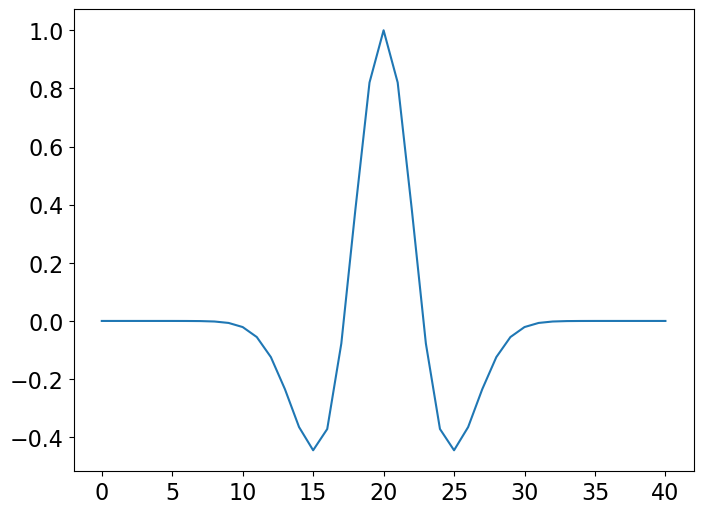

In [5]:
# Axes
nx, nz = 101, 61
dx, dz = 10, 10
nt, dt = 301, 0.004

x, z = np.arange(nx) * dx, np.arange(nz) * dz
t =  np.arange(nt) * dt

# Velocity and refl.
v0 = 1500
v = v0 * np.ones((nx, nz))

refl = np.zeros((nx, nz))
refl[nx//2, nz//2] = 1
refl[nx//4, nz//2] = 1
refl[3*nx//4, nz//2] = 1
refl[:, 2*nz//3] = 1

# Geometry
ns, nr = nx, nx
s = np.vstack([x, np.zeros(nx)])
r = np.vstack([x, 30*np.ones(nx)])

# Wavelet
wav, _, wavc = ricker(t[:21], f0=20)
plt.plot(wav)

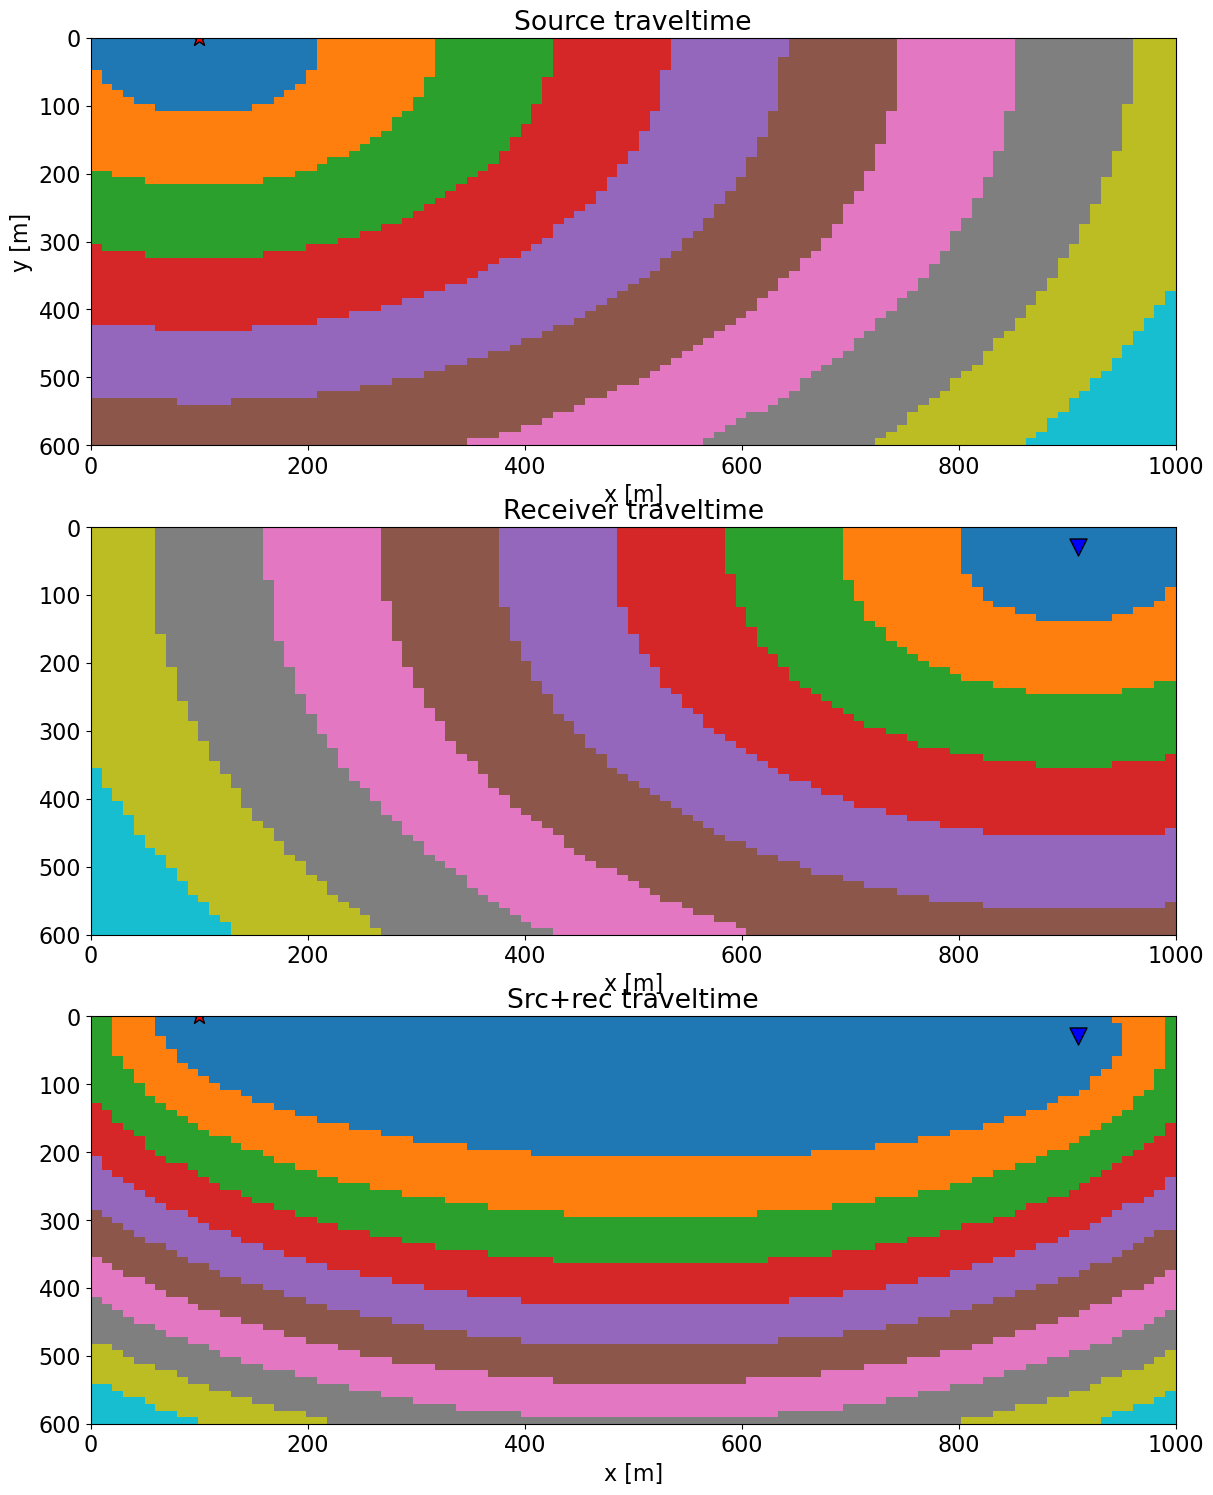

In [6]:
trav_srcs, trav_recs, _, _, _, _ = \
    Kirchhoff._traveltime_table(z, x, s, r, v0, mode='analytic')

fig, axs = plt.subplots(3, 1, sharey=True, figsize=(14, 18))
axs[0].imshow(trav_srcs[:, 10].reshape((nx, nz)).T, cmap='tab10', 
              extent = (x[0], x[-1], z[-1], z[0]))
axs[0].scatter(s[0, 10], s[1, 10], marker='*', s=150, c='r', edgecolors='k')
axs[0].axis('tight')
axs[0].set_xlabel('x [m]')
axs[0].set_ylabel('y [m]')
axs[0].set_title('Source traveltime')
axs[0].set_ylim(z[-1], z[0])
axs[1].imshow(trav_recs[:, -10].reshape((nx, nz)).T, cmap='tab10', 
              extent = (x[0], x[-1], z[-1], z[0]))
axs[1].scatter(r[0, -10], r[1, -10], marker='v', s=150, c='b', edgecolors='k')
axs[1].axis('tight')
axs[1].set_xlabel('x [m]')
axs[1].set_title('Receiver traveltime')
axs[1].set_ylim(z[-1], z[0])
axs[2].imshow(trav_srcs[:, 10].reshape((nx, nz)).T + trav_recs[:, -10].reshape((nx, nz)).T, 
              cmap='tab10', extent = (x[0], x[-1], z[-1], z[0]))
axs[2].scatter(s[0, 10], s[1, 10], marker='*', s=150, c='r', edgecolors='k')
axs[2].scatter(r[0, -10], r[1, -10], marker='v', s=150, c='b', edgecolors='k')
axs[2].axis('tight')
axs[2].set_xlabel('x [m]')
axs[2].set_title('Src+rec traveltime')
axs[2].set_ylim(z[-1], z[0]);

In [7]:
# Convert from src-rec to mid-off
doff = 10
noff = 41
off = np.arange(noff) * doff - noff//2 * doff

mid = x.copy()
nmid = mid.size

trav_mid_off, fold_mid_off = trav_srcrec_to_midoff(trav_srcs, trav_recs, s[0], r[0], mid, off)

0.0 1.0


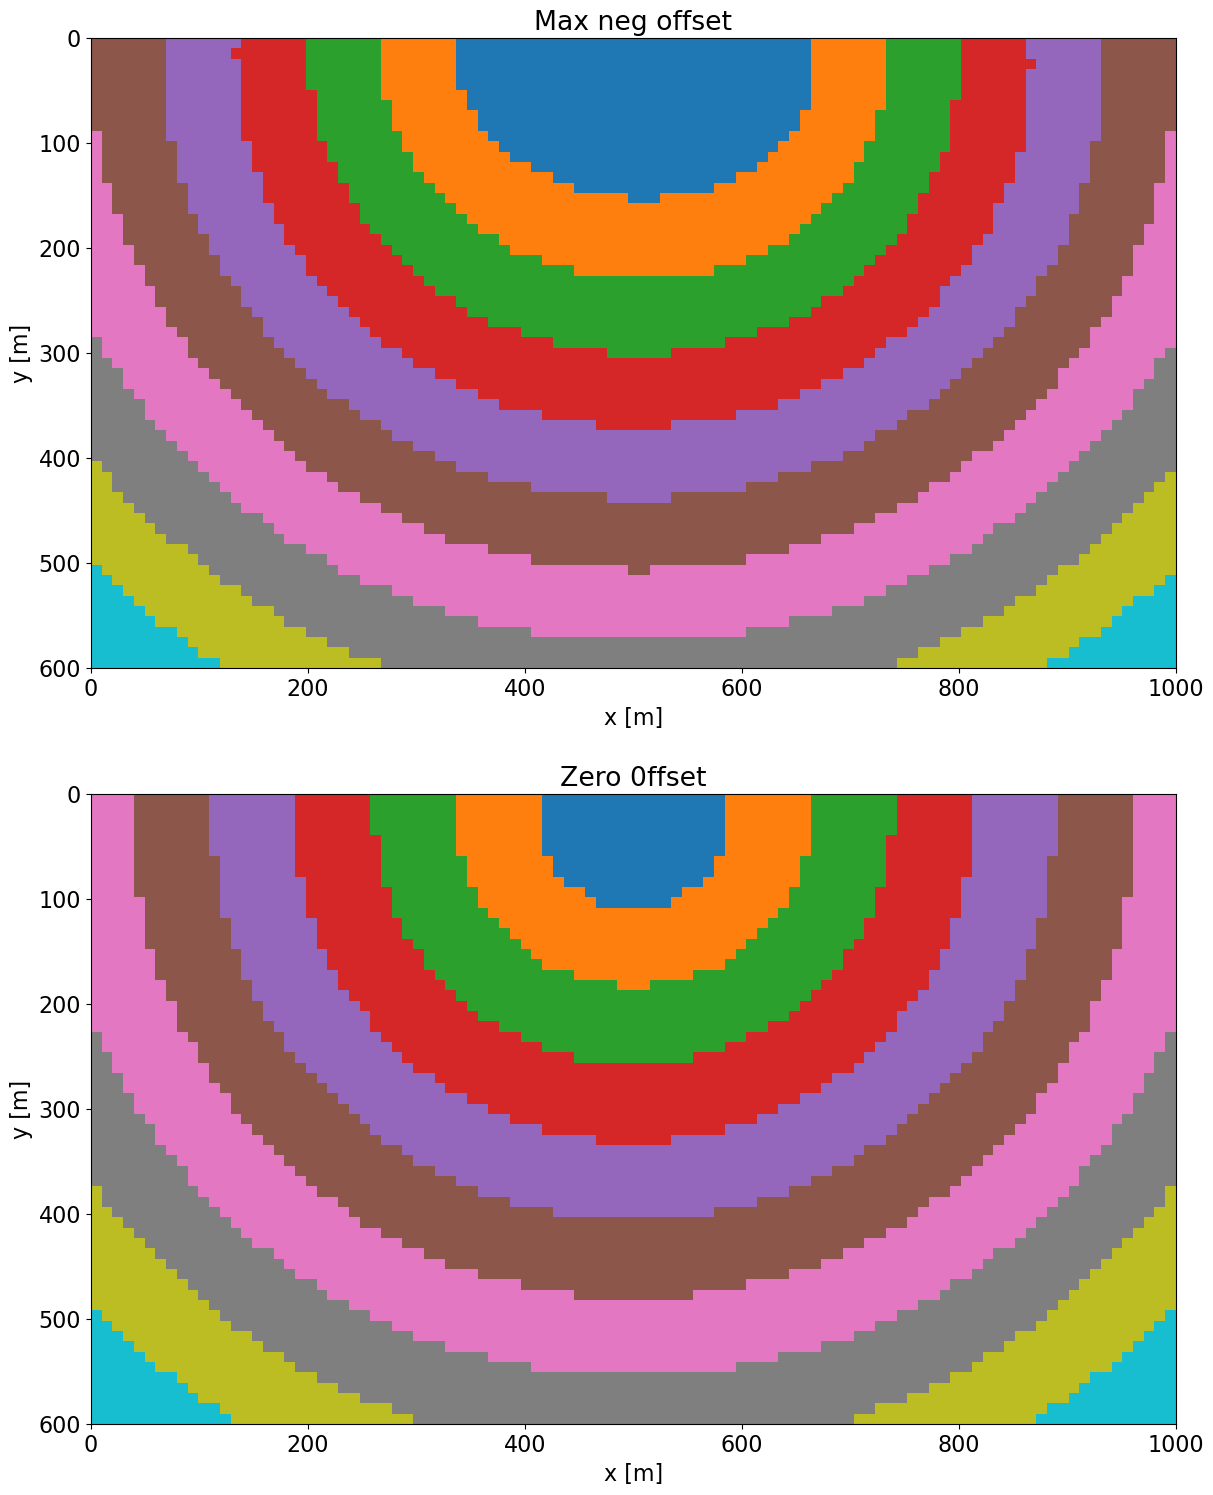

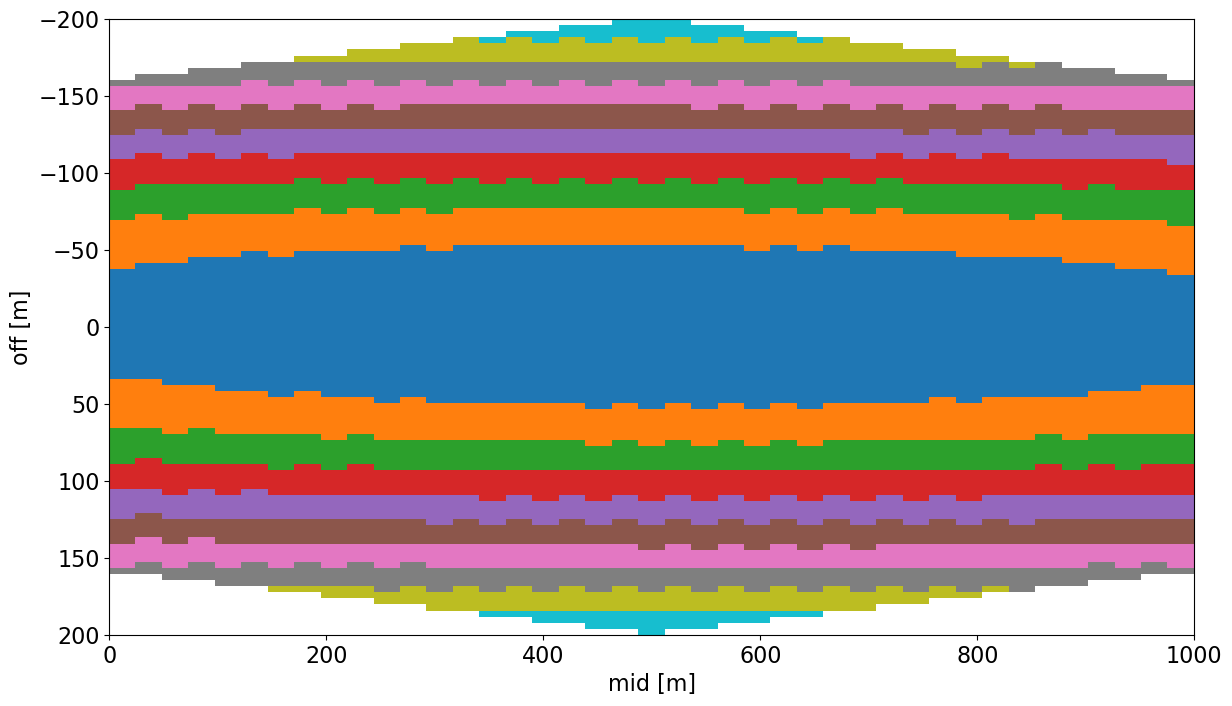

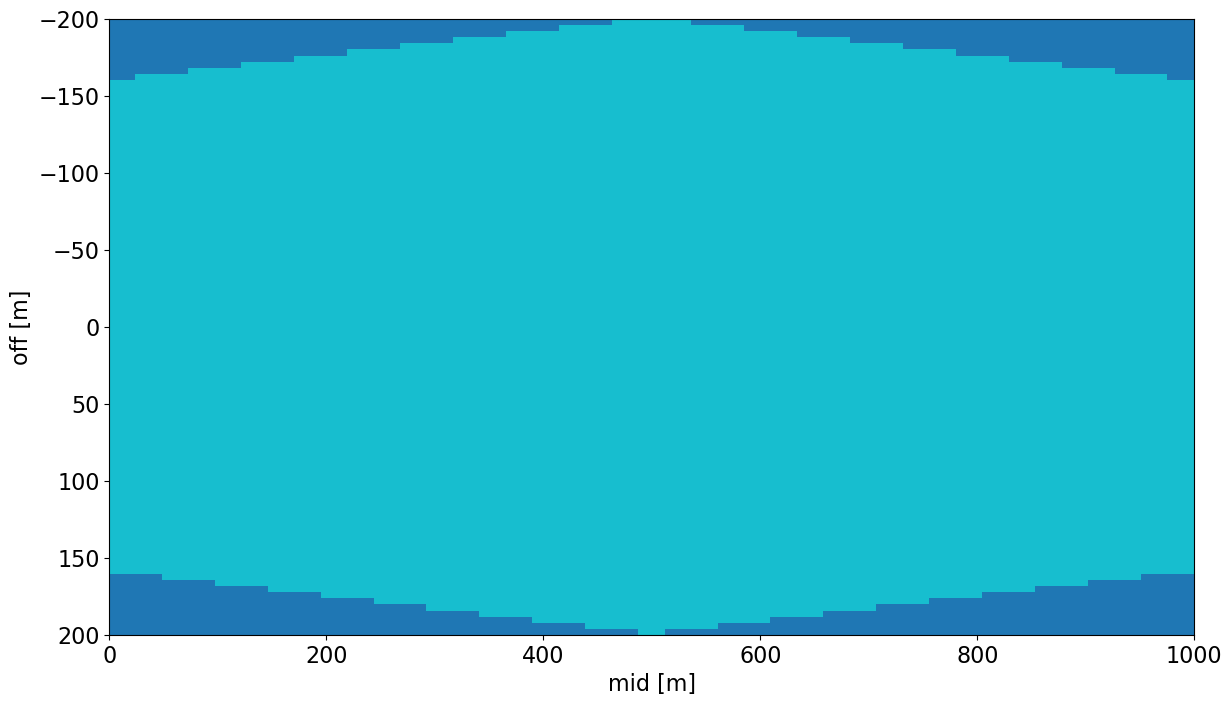

In [8]:
fig, axs = plt.subplots(2, 1, sharey=True, figsize=(14, 18))
axs[0].imshow(trav_mid_off[nx//2, 0].reshape((nx, nz)).T, cmap='tab10', 
              extent = (x[0], x[-1], z[-1], z[0]))
axs[0].axis('tight')
axs[0].set_xlabel('x [m]')
axs[0].set_ylabel('y [m]')
axs[0].set_title('Max neg offset')
axs[1].imshow(trav_mid_off[nx//2, noff//2].reshape((nx, nz)).T, cmap='tab10', 
              extent = (x[0], x[-1], z[-1], z[0]))
axs[1].axis('tight')
axs[1].set_xlabel('x [m]')
axs[1].set_ylabel('y [m]')
axs[1].set_title('Zero 0ffset')

fig, axs = plt.subplots(1, 1, sharey=True, figsize=(14, 8))
axs.imshow(trav_mid_off.reshape(nmid, noff, nx, nz)[:, :, nx//2, nz//2], cmap='tab10', 
           extent = (mid[0], mid[-1], off[-1], off[0]))
axs.axis('tight')
axs.set_xlabel('mid [m]')
axs.set_ylabel('off [m]');

fig, axs = plt.subplots(1, 1, sharey=True, figsize=(14, 8))
axs.imshow(fold_mid_off, cmap='tab10', 
           extent = (mid[0], mid[-1], off[-1], off[0]))
axs.axis('tight')
axs.set_xlabel('mid [m]')
axs.set_ylabel('off [m]')

print(fold_mid_off.min(), fold_mid_off.max())

In [9]:
data = np.zeros((noff, nx, nt))
reflmig = np.zeros((noff, nx, nz))

for ioff in range(noff):
    print(f'Working with {ioff}/{noff}')
    tmidoff = trav_mid_off[:, ioff].reshape(nmid, nx, nz)
    tmidoff[np.isnan(tmidoff)] = -1
    Kop = OffKirchhoff(z, x, t, mid, wav, wavc, tmidoff, engine='numba')
    #dottest(Kop)
    data[ioff] = Kop @ refl
    reflmig[ioff] = Kop.H @ data[ioff]

Working with 0/41


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Working with 1/41
Working with 2/41
Working with 3/41
Working with 4/41
Working with 5/41
Working with 6/41
Working with 7/41
Working with 8/41
Working with 9/41
Working with 10/41
Working with 11/41
Working with 12/41
Working with 13/41
Working with 14/41
Working with 15/41
Working with 16/41
Working with 17/41
Working with 18/41
Working with 19/41
Working with 20/41
Working with 21/41
Working with 22/41
Working with 23/41
Working with 24/41
Working with 25/41
Working with 26/41
Working with 27/41
Working with 28/41
Working with 29/41
Working with 30/41
Working with 31/41
Working with 32/41
Working with 33/41
Working with 34/41
Working with 35/41
Working with 36/41
Working with 37/41
Working with 38/41
Working with 39/41
Working with 40/41


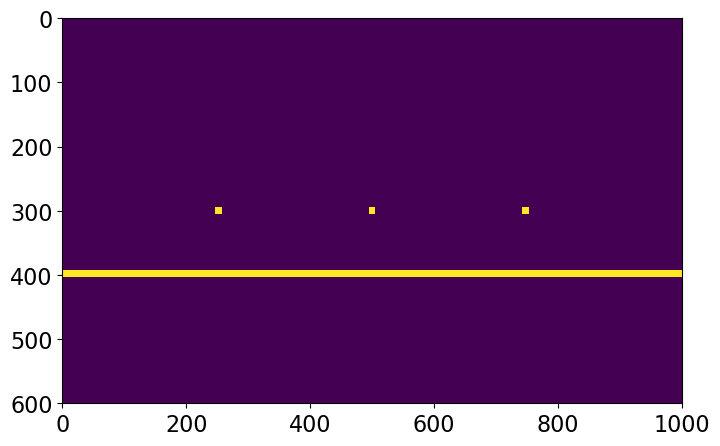

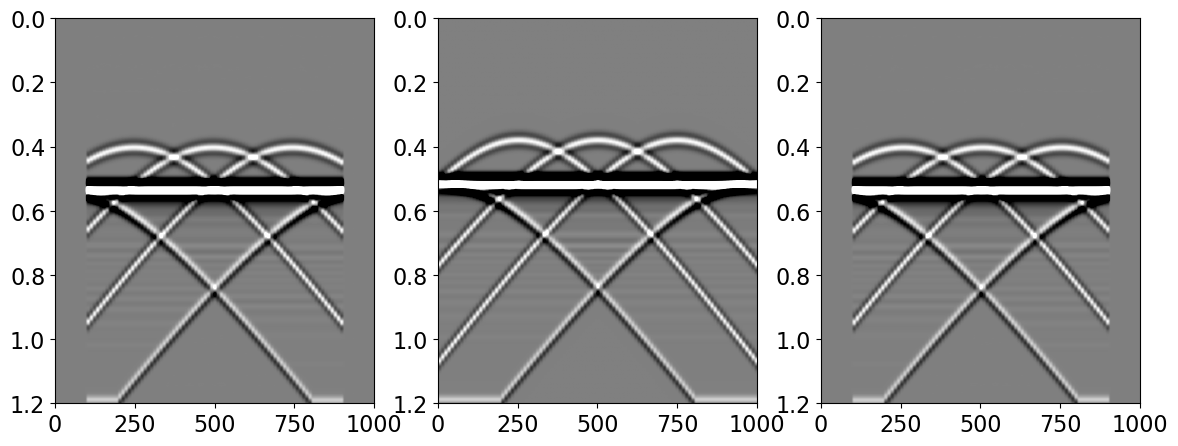

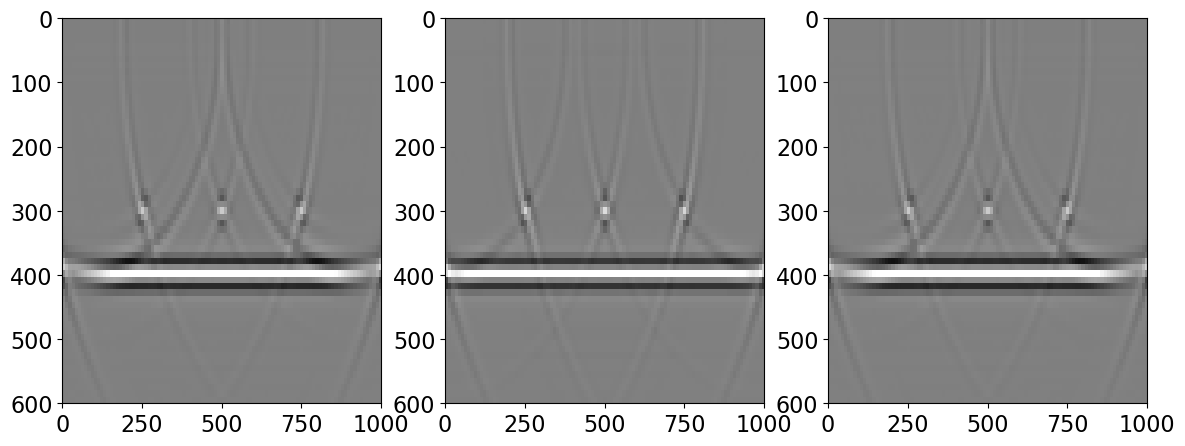

In [10]:
plt.figure(figsize=(8, 5))
plt.imshow(refl.T, extent=(x[0], x[-1], z[-1], z[0]))
plt.axis('tight')

fig, axs = plt.subplots(1, 3, figsize=(14, 5))
axs[0].imshow(data[0].T, cmap='gray', vmin=-1, vmax=1, extent=(mid[0], mid[-1], t[-1], t[0]))
axs[0].axis('tight')
axs[1].imshow(data[noff//2].T, cmap='gray', vmin=-1, vmax=1, extent=(mid[0], mid[-1], t[-1], t[0]))
axs[1].axis('tight')
axs[2].imshow(data[-1].T, cmap='gray', vmin=-1, vmax=1, extent=(mid[0], mid[-1], t[-1], t[0]))
axs[2].axis('tight')

fig, axs = plt.subplots(1, 3, figsize=(14, 5))
axs[0].imshow(reflmig[0].T, cmap='gray', vmin=-5e2, vmax=5e2, extent=(x[0], x[-1], z[-1], z[0]))
axs[0].axis('tight')
axs[1].imshow(reflmig[noff//2].T, cmap='gray', vmin=-5e2, vmax=5e2, extent=(x[0], x[-1], z[-1], z[0]))
axs[1].axis('tight')
axs[2].imshow(reflmig[-1].T, cmap='gray', vmin=-5e2, vmax=5e2, extent=(x[0], x[-1], z[-1], z[0]))
axs[2].axis('tight');

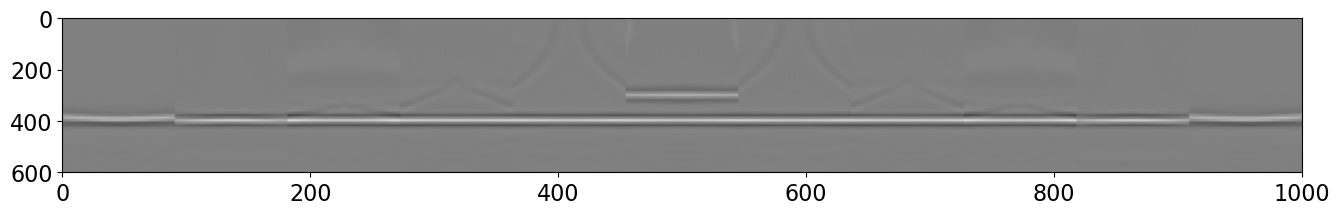

In [11]:
plt.figure(figsize=(16, 2))
plt.imshow(reflmig[:, ::10].transpose(1, 0, 2).reshape(noff*(nx//10+1), nz).T, cmap='gray', vmin=-1e3, vmax=1e3, 
           extent=(x[0], x[-1], z[-1], z[0]))
plt.axis('tight');

## Volve

### Model, geometry, and data

In [12]:
# Jump on sources / recs (for quick testing)
js = 1
jr = 2

50.083984 49.84131


(-0.1, 0.1)

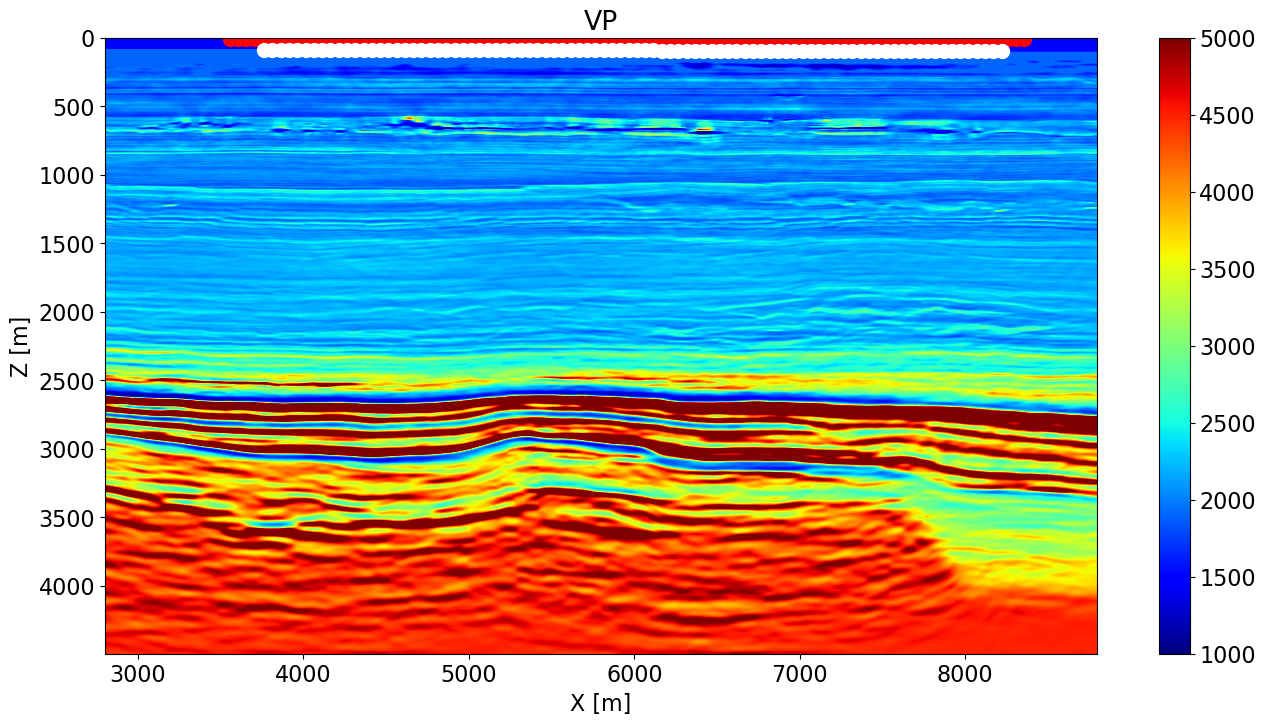

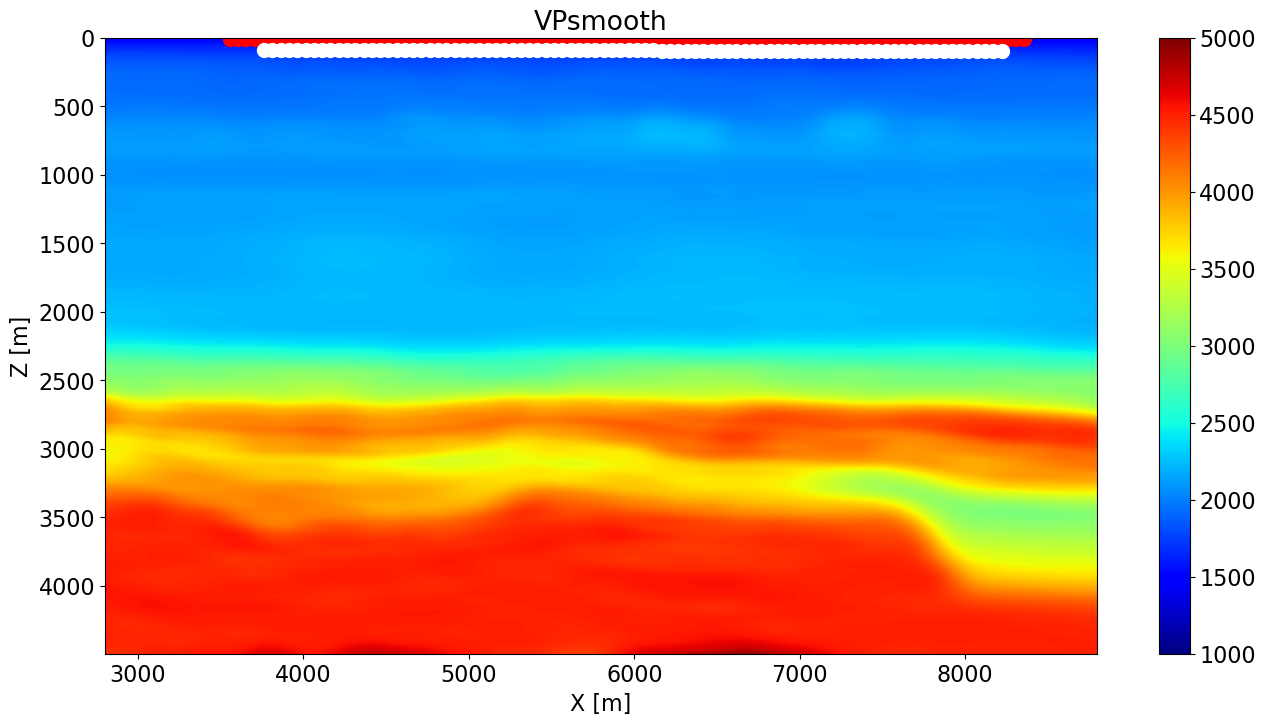

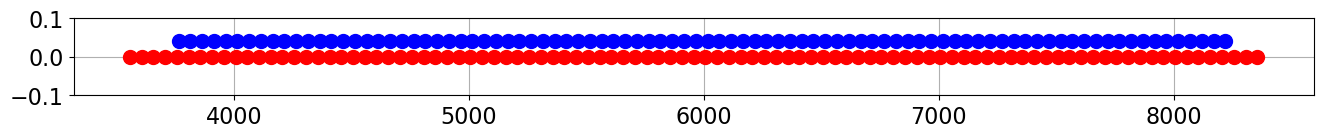

In [13]:
# Load from input file
inputdata = np.load('input_nofs_full_volvesynth.npz')

# Velocity 
vel = inputdata["vel"].T

# Smooth velocity
nsmooth = 41
smooth = np.ones(nsmooth)/nsmooth
velsm = filtfilt(smooth, 1, filtfilt(smooth, 1, vel).T).T
 
nx, nz = vel.shape
x = inputdata["x"]
z = inputdata["z"]
s = inputdata["s"][:, 11:-2][:, ::js]
r = inputdata["r"][:, ::jr]
ns, nr = s.shape[1], r.shape[1]
ds, dr = s[0,1]-s[0,0], r[0,1]-r[0,0]
print(ds, dr)
t = inputdata['t']
dt = t[1]
d = inputdata['p'].transpose(0, 2, 1)[11:-2][::js, ::jr]

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
im = ax.imshow(vel.T, cmap='jet', vmin=1000, vmax=5000, extent=(x[0], x[-1], z[-1], z[0]))
ax.plot(s[0], s[1], '.r', ms=20)
ax.plot(r[0], r[1], '.w', ms=20)
ax.set_xlabel(r'X [m]')
ax.set_ylabel(r'Z [m]')
ax.set_title(r'VP')
ax.axis('tight')
plt.colorbar(im);

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
im = ax.imshow(velsm.T, cmap='jet', vmin=1000, vmax=5000, extent=(x[0], x[-1], z[-1], z[0]))
ax.plot(s[0], s[1], '.r', ms=20)
ax.plot(r[0], r[1], '.w', ms=20)
ax.set_xlabel(r'X [m]')
ax.set_ylabel(r'Z [m]')
ax.set_title(r'VPsmooth')
ax.axis('tight')
plt.colorbar(im);

plt.figure(figsize=(16, 1))
plt.plot(s[0], 0*s[1], '.r', ms=20)
plt.plot(r[0], 0.04+0*r[1], '.b', ms=20)
plt.grid();
plt.ylim(-0.1, 0.1)

### Convert from global to local grid

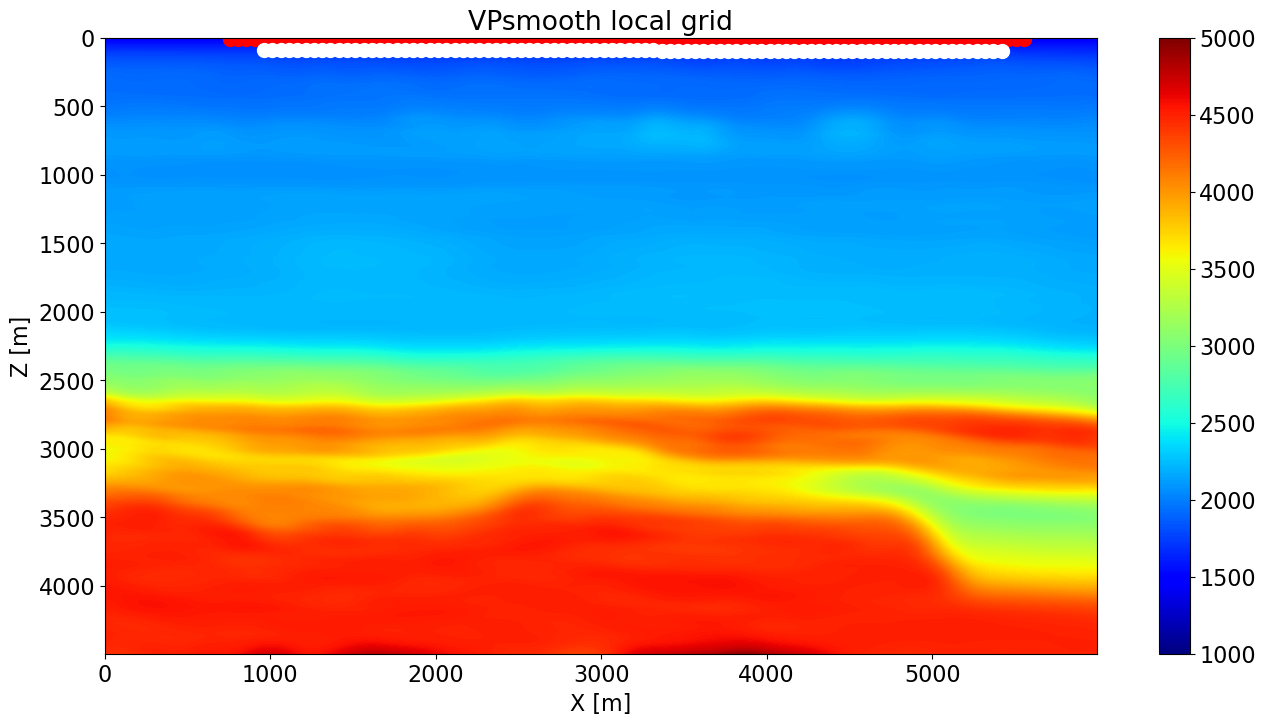

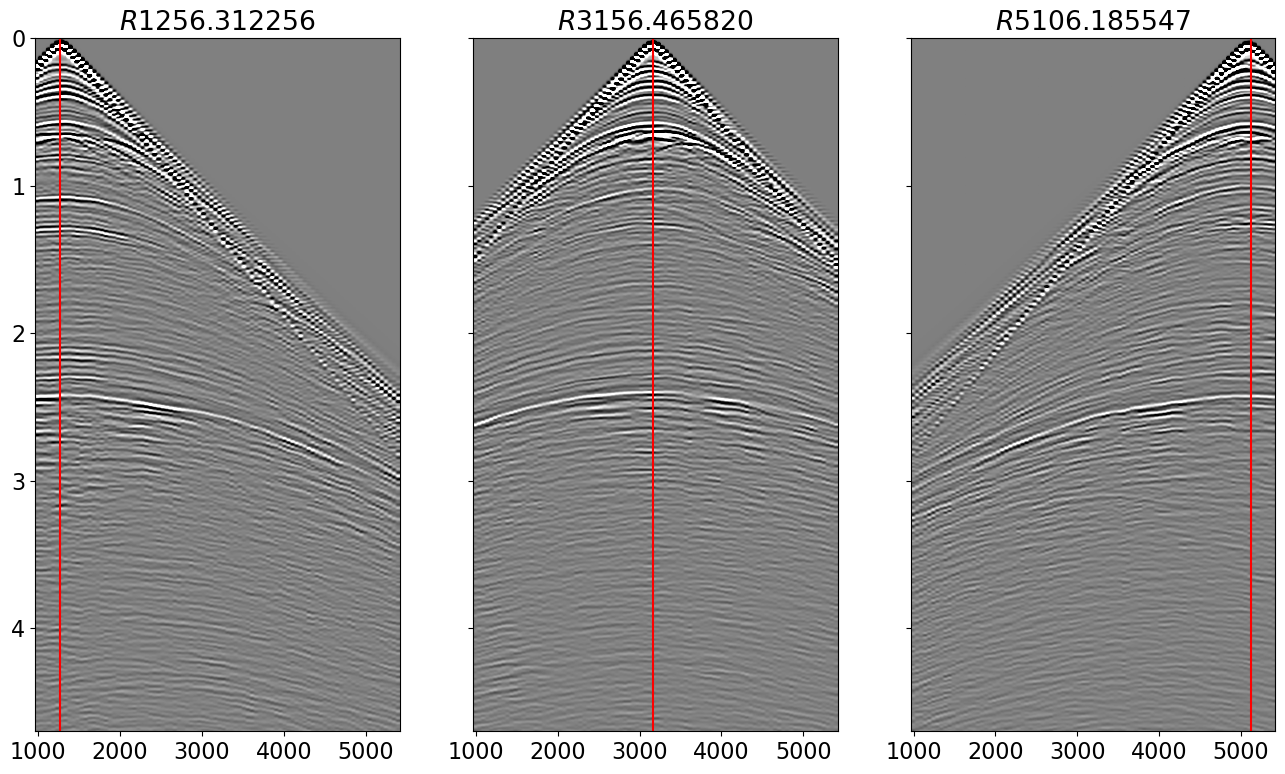

In [14]:
xorig = x[0]
x -= xorig
dx, dz = x[1], z[1]

s[0] -= xorig
r[0] -= xorig

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
im = ax.imshow(velsm.T, cmap='jet', vmin=1000, vmax=5000, extent=(x[0], x[-1], z[-1], z[0]))
ax.plot(s[0], s[1], '.r', ms=20)
ax.plot(r[0], r[1], '.w', ms=20)
ax.set_xlabel(r'X [m]')
ax.set_ylabel(r'Z [m]')
ax.set_title(r'VPsmooth local grid')
ax.axis('tight')
plt.colorbar(im)

clip = 0.02
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(d[10].T, cmap='gray', vmin=-clip*np.abs(d).max(), vmax=clip*np.abs(d).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0].axvline(r[0, np.argmin(np.abs(s[0,10]-r[0]))], color='r')
axs[0].set_title(r'$R%f$' % s[0, 10])
axs[0].axis('tight')
axs[1].imshow(d[ns//2].T, cmap='gray', vmin=-clip*np.abs(d).max(), vmax=clip*np.abs(d).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[1].axvline(r[0, np.argmin(np.abs(s[0,ns//2]-r[0]))], color='r')
axs[1].set_title(r'$R%f$' % s[0, ns//2])
axs[1].axis('tight')
axs[2].imshow(d[-10].T, cmap='gray', vmin=-clip*np.abs(d).max(), vmax=clip*np.abs(d).max(),
              extent = (r[0,0],r[0,-1], t[-1], t[0]))
axs[2].axvline(r[0, np.argmin(np.abs(s[0,-10]-r[0]))], color='r')
axs[2].set_title(r'$R%f$' % s[0, -10])
axs[2].axis('tight');

### Kirchhoff Migration

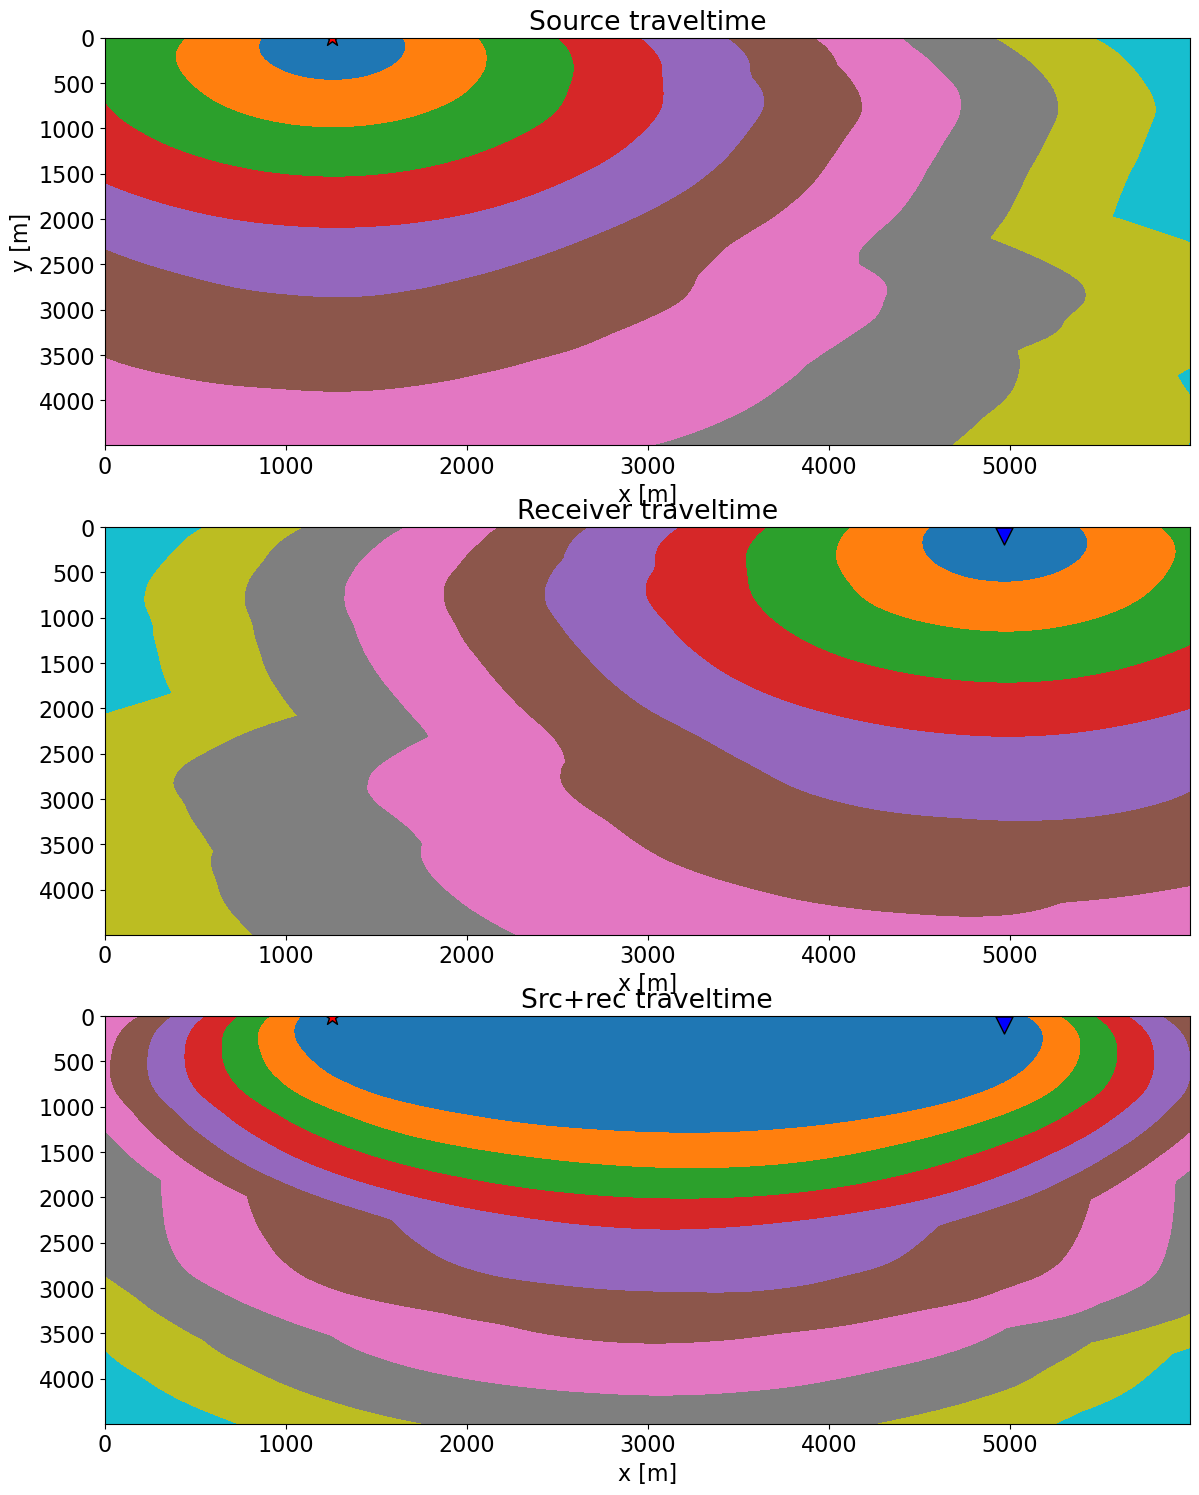

In [15]:
trav_srcs, trav_recs, _, _, _, _ = \
    Kirchhoff._traveltime_table(z, x, s, r, velsm, mode='eikonal')

fig, axs = plt.subplots(3, 1, sharey=True, figsize=(14, 18))
axs[0].imshow(trav_srcs[:, 10].reshape((nx, nz)).T, cmap='tab10', 
              extent = (x[0], x[-1], z[-1], z[0]))
axs[0].scatter(s[0, 10], s[1, 10], marker='*', s=150, c='r', edgecolors='k')
axs[0].axis('tight')
axs[0].set_xlabel('x [m]')
axs[0].set_ylabel('y [m]')
axs[0].set_title('Source traveltime')
axs[0].set_ylim(z[-1], z[0])
axs[1].imshow(trav_recs[:, -10].reshape((nx, nz)).T, cmap='tab10', 
              extent = (x[0], x[-1], z[-1], z[0]))
axs[1].scatter(r[0, -10], r[1, -10], marker='v', s=150, c='b', edgecolors='k')
axs[1].axis('tight')
axs[1].set_xlabel('x [m]')
axs[1].set_title('Receiver traveltime')
axs[1].set_ylim(z[-1], z[0])
axs[2].imshow(trav_srcs[:, 10].reshape((nx, nz)).T + trav_recs[:, -10].reshape((nx, nz)).T, 
              cmap='tab10', extent = (x[0], x[-1], z[-1], z[0]))
axs[2].scatter(s[0, 10], s[1, 10], marker='*', s=150, c='r', edgecolors='k')
axs[2].scatter(r[0, -10], r[1, -10], marker='v', s=150, c='b', edgecolors='k')
axs[2].axis('tight')
axs[2].set_xlabel('x [m]')
axs[2].set_title('Src+rec traveltime')
axs[2].set_ylim(z[-1], z[0]);

In [16]:
# Convert from src-rec to mid-off
doff = 100
noff = 21
off = np.arange(noff) * doff - noff//2 * doff

nmid = nr
mid = np.linspace(r[0,0], r[0,-1], nmid)

trav_mid_off, fold_mid_off = trav_srcrec_to_midoff(trav_srcs, trav_recs, s[0], r[0], mid, off)

0.0 4.0


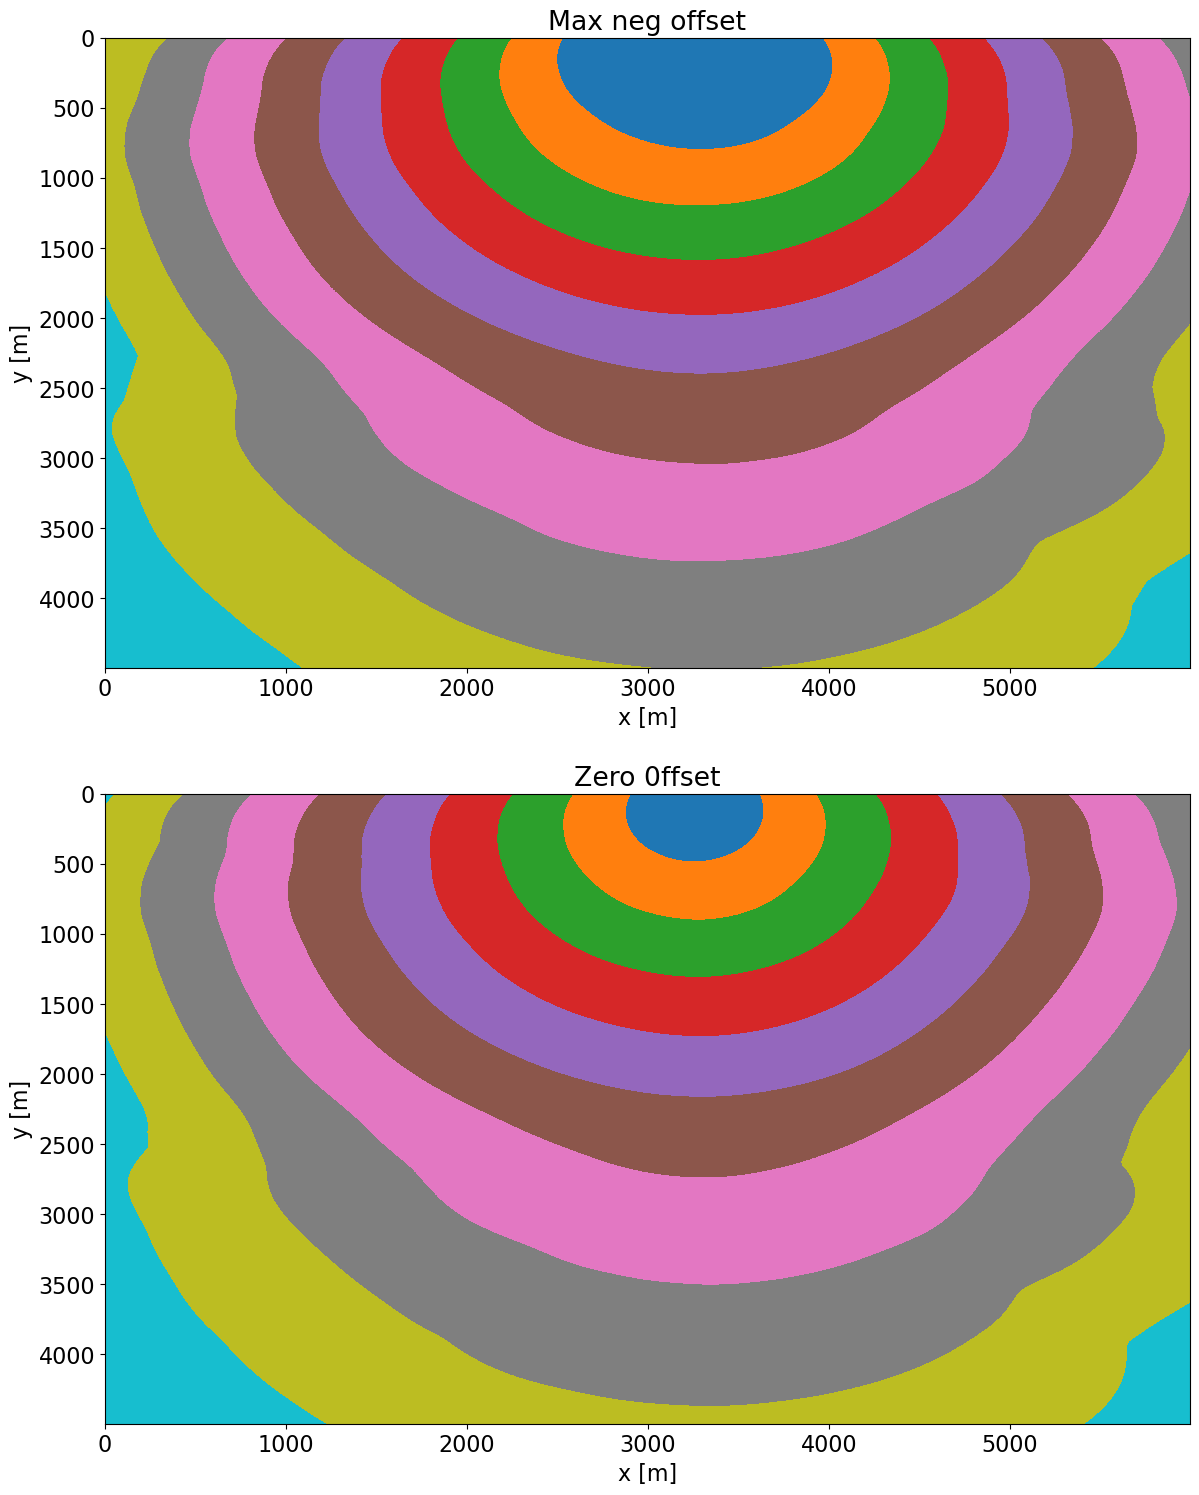

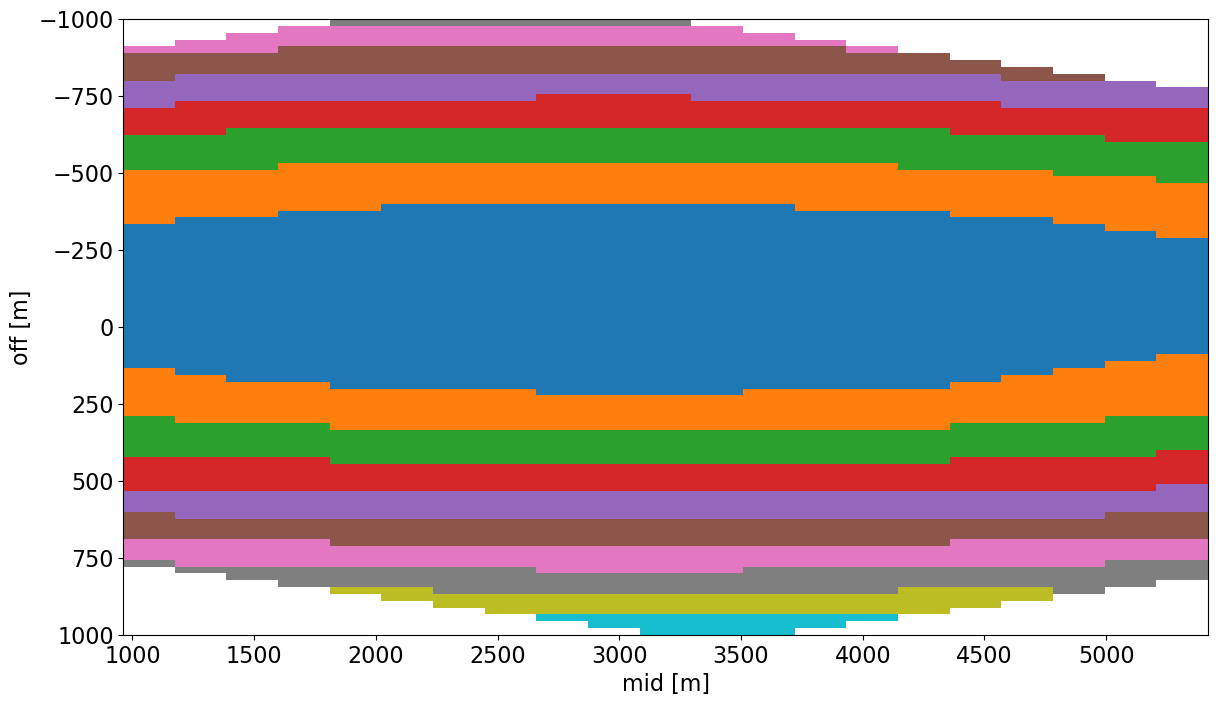

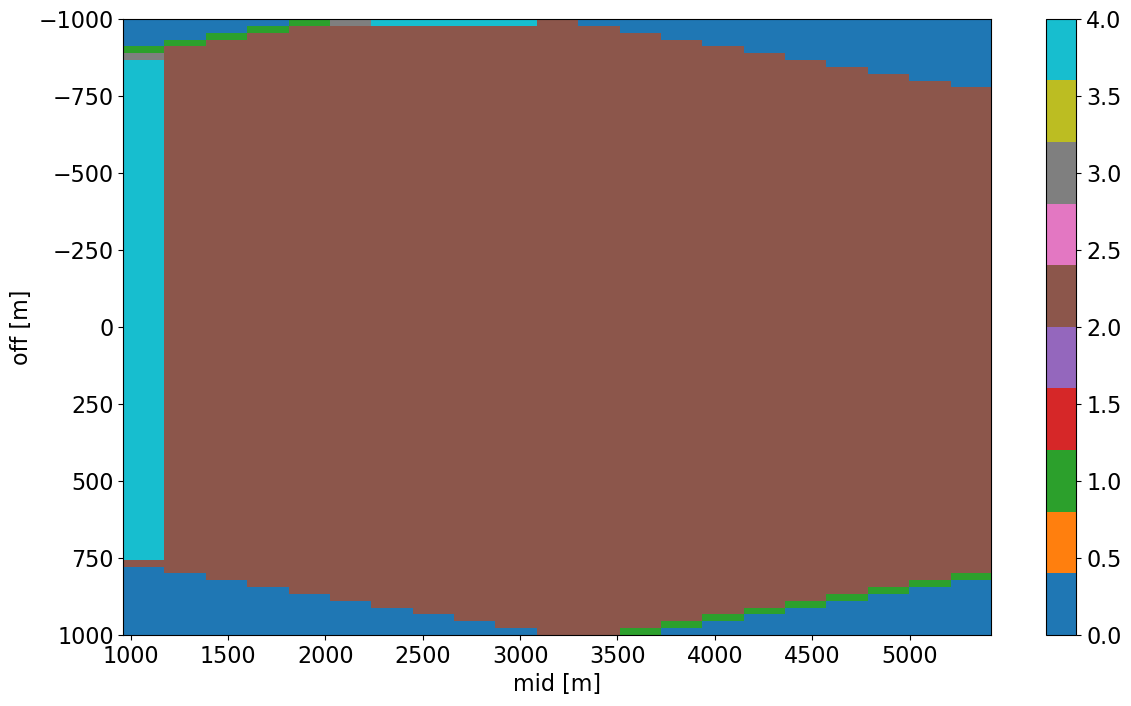

In [17]:
fig, axs = plt.subplots(2, 1, sharey=True, figsize=(14, 18))
axs[0].imshow(trav_mid_off[nmid//2, 0].reshape((nx, nz)).T, cmap='tab10', 
              extent = (x[0], x[-1], z[-1], z[0]))
axs[0].axis('tight')
axs[0].set_xlabel('x [m]')
axs[0].set_ylabel('y [m]')
axs[0].set_title('Max neg offset')
axs[1].imshow(trav_mid_off[nmid//2, noff//2].reshape((nx, nz)).T, cmap='tab10', 
              extent = (x[0], x[-1], z[-1], z[0]))
axs[1].axis('tight')
axs[1].set_xlabel('x [m]')
axs[1].set_ylabel('y [m]')
axs[1].set_title('Zero 0ffset')

fig, axs = plt.subplots(1, 1, sharey=True, figsize=(14, 8))
axs.imshow(trav_mid_off.reshape(nmid, noff, nx, nz)[:, :, nx//2, nz//2], cmap='tab10', 
           extent = (mid[0], mid[-1], off[-1], off[0]))
axs.axis('tight')
axs.set_xlabel('mid [m]')
axs.set_ylabel('off [m]')

fig, axs = plt.subplots(1, 1, sharey=True, figsize=(14, 8))
im = axs.imshow(fold_mid_off, cmap='tab10', 
           extent = (mid[0], mid[-1], off[-1], off[0]))
axs.axis('tight')
axs.set_xlabel('mid [m]')
axs.set_ylabel('off [m]')
plt.colorbar(im)

print(fold_mid_off.min(), fold_mid_off.max());

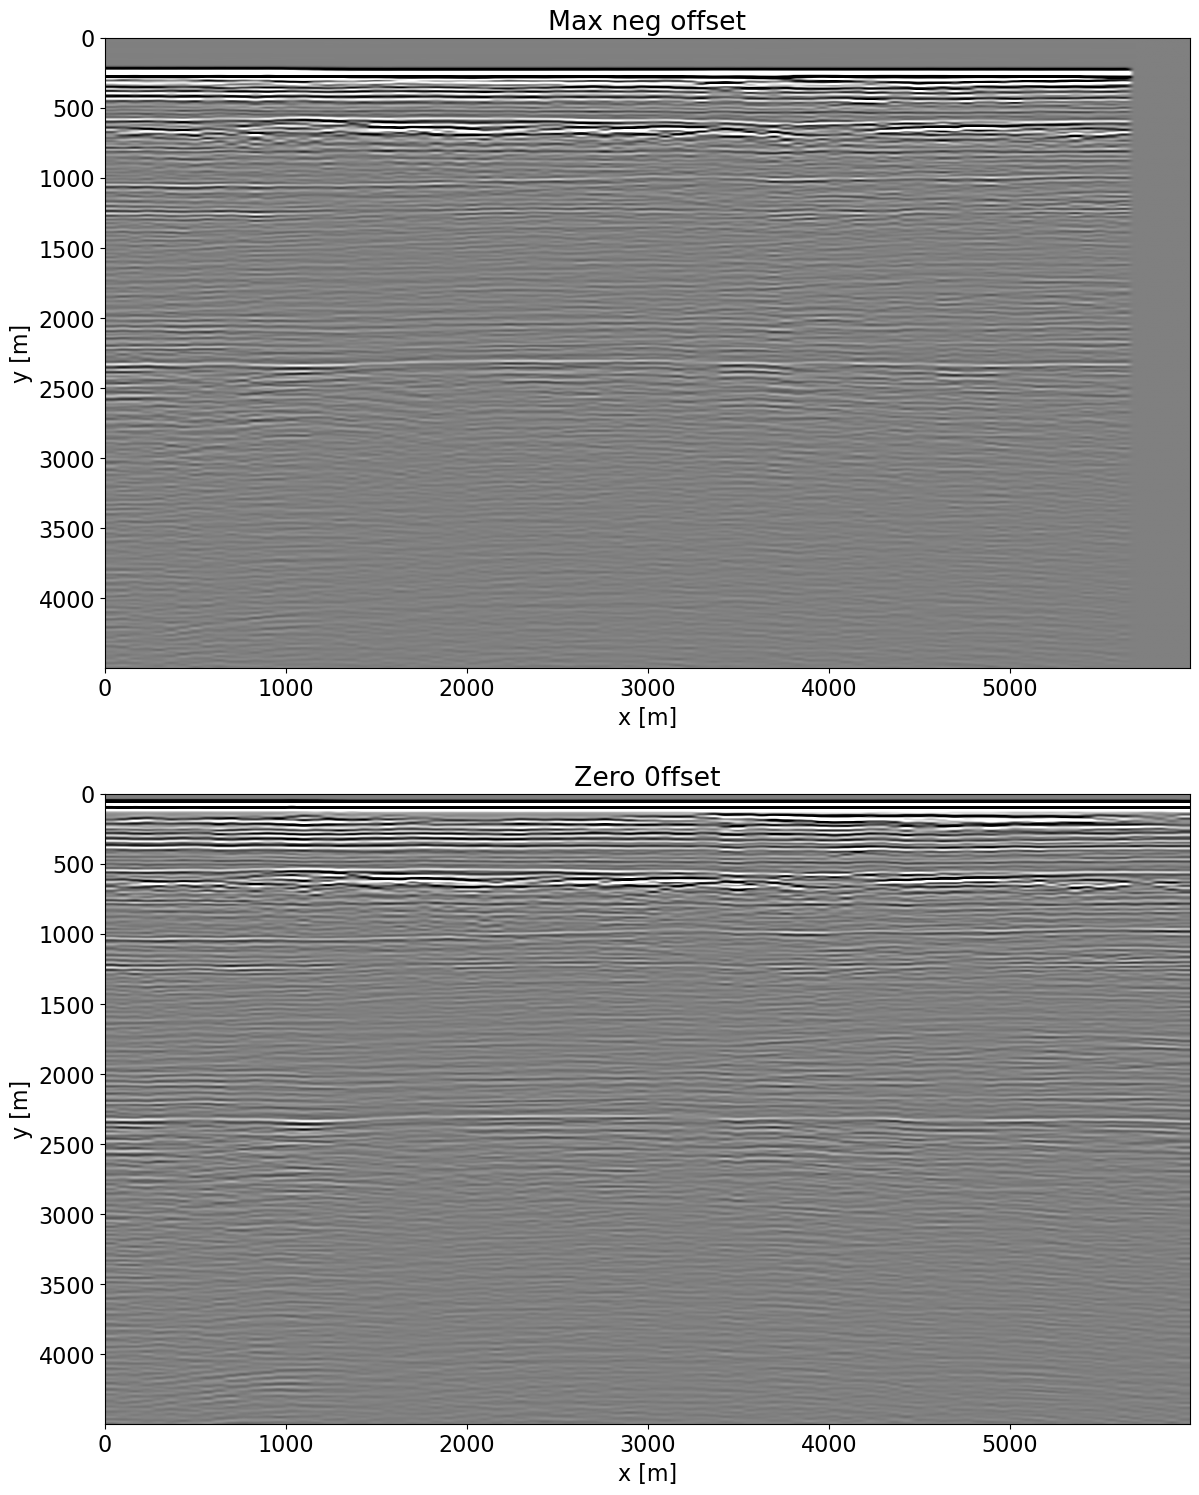

In [18]:
data_mid_off, fold_mid_off = data_srcrec_to_midoff(d, s[0], r[0], mid, off, d.shape[-1])
fig, axs = plt.subplots(2, 1, sharey=True, figsize=(14, 18))
axs[0].imshow(data_mid_off[:, noff//2-5].T, cmap='gray', vmin=-4e2, vmax=4e2, 
              extent = (x[0], x[-1], z[-1], z[0]))
axs[0].axis('tight')
axs[0].set_xlabel('x [m]')
axs[0].set_ylabel('y [m]')
axs[0].set_title('Max neg offset')
axs[1].imshow(data_mid_off[:, noff//2].T, cmap='gray', vmin=-4e2, vmax=4e2, 
              extent = (x[0], x[-1], z[-1], z[0]))
axs[1].axis('tight')
axs[1].set_xlabel('x [m]')
axs[1].set_ylabel('y [m]')
axs[1].set_title('Zero 0ffset');

In [19]:
#wav, wavt, wavc = ricker(t[:41], f0=20)
wav, wavc = np.zeros(81), 41
wav[wavc] = 1.
#plt.figure()
#plt.plot(wav)

reflmig = np.zeros((noff, nx, nz))

for ioff in range(noff):
    print(f'Working with {ioff}/{noff}')
    Kop = OffKirchhoff(z, x, t, mid, wav, wavc, trav_mid_off[:, ioff].reshape(nmid, nx, nz), engine='numba')
    reflmig[ioff] = Kop.H @ data_mid_off[:, ioff]

Working with 0/21
Working with 1/21
Working with 2/21
Working with 3/21
Working with 4/21
Working with 5/21
Working with 6/21
Working with 7/21
Working with 8/21
Working with 9/21
Working with 10/21
Working with 11/21
Working with 12/21
Working with 13/21
Working with 14/21
Working with 15/21
Working with 16/21
Working with 17/21
Working with 18/21
Working with 19/21
Working with 20/21


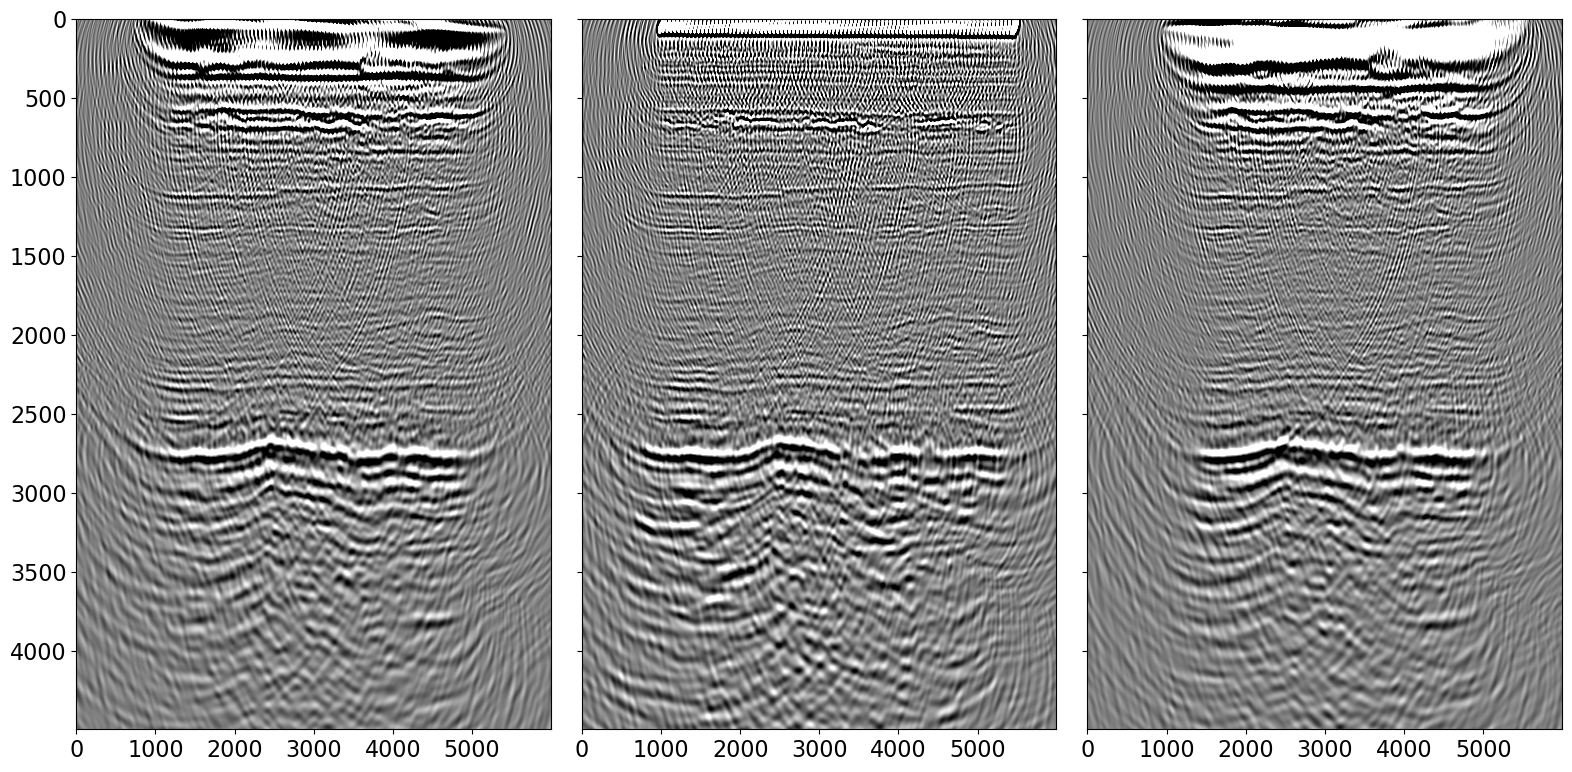

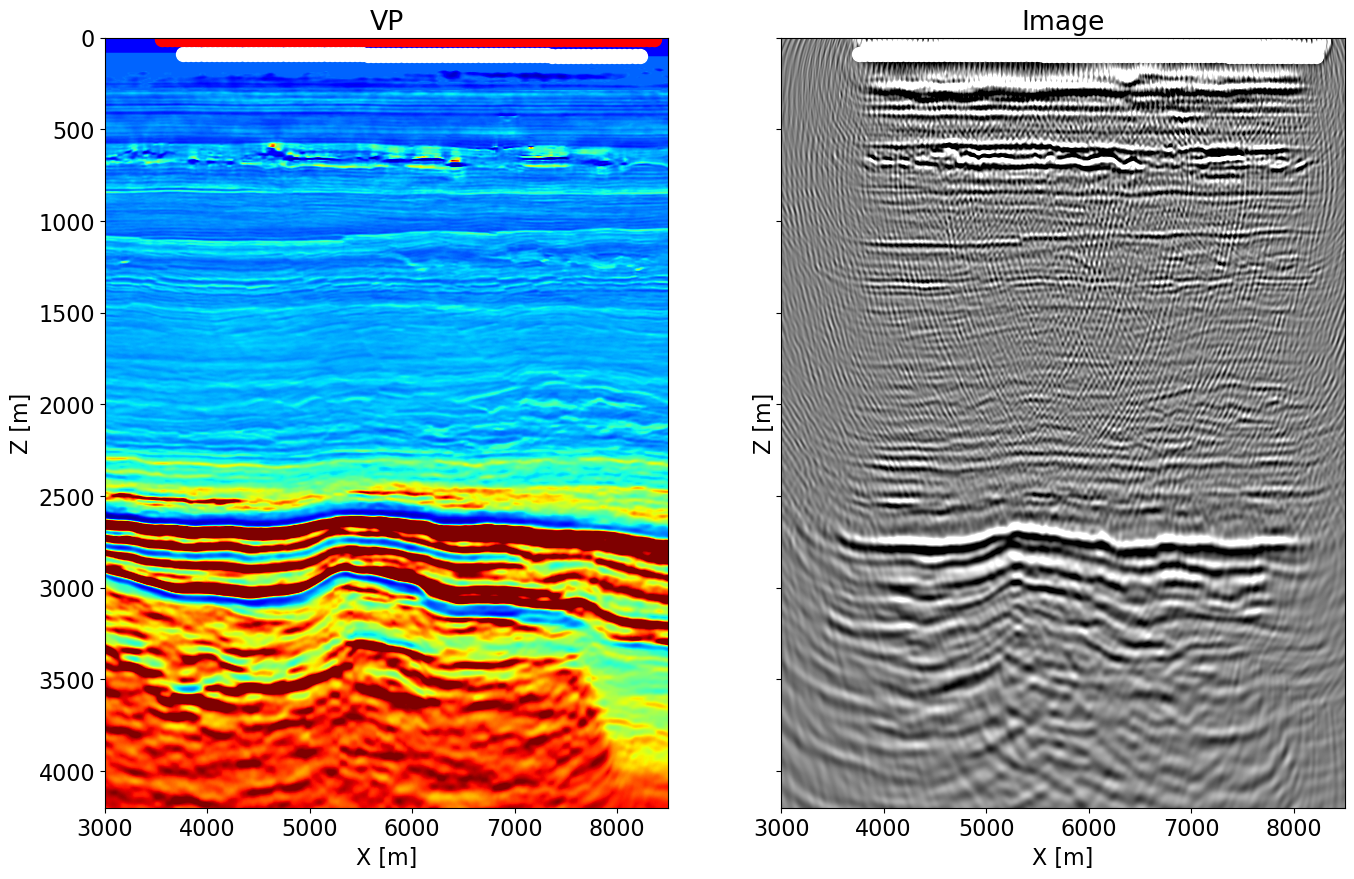

In [30]:
fig, axs = plt.subplots(1, 3, sharey=True,figsize=(16, 8))
axs[0].imshow(reflmig[0].T, cmap='gray', vmin=-1e3, vmax=1e3, extent=(x[0], x[-1], z[-1], z[0]))
axs[0].axis('tight')
axs[1].imshow(reflmig[noff//2].T, cmap='gray', vmin=-1e3, vmax=1e3, extent=(x[0], x[-1], z[-1], z[0]))
axs[1].axis('tight')
axs[2].imshow(reflmig[-1].T, cmap='gray', vmin=-1e3, vmax=1e3, extent=(x[0], x[-1], z[-1], z[0]))
axs[2].axis('tight');
plt.tight_layout()

fig, (ax, ax1) = plt.subplots(1, 2, sharey=True, figsize=(16, 10))
ax.imshow(vel.T, cmap='jet', vmin=1000, vmax=5000, extent=(x[0]+xorig, x[-1]+xorig, z[-1], z[0]))
ax.plot(s[0]+xorig, s[1], '.r', ms=20)
ax.plot(r[0]+xorig, r[1], '.w', ms=20)
ax.set_xlabel(r'X [m]')
ax.set_ylabel(r'Z [m]')
ax.set_title(r'VP')
ax.axis('tight')
ax.set_xlim(3000, 8500)
ax1.imshow(np.sum(reflmig, axis=0).T, cmap='gray', vmin=-2e4, vmax=2e4, 
           interpolation='sinc', extent=(x[0]+xorig, x[-1]+xorig, z[-1], z[0]))
ax.plot(s[0]+xorig, s[1], '.r', ms=20)
ax1.plot(r[0]+xorig, r[1], '.w', ms=20)
ax1.set_xlabel(r'X [m]')
ax1.set_ylabel(r'Z [m]')
ax1.set_title(r'Image')
ax1.axis('tight')
ax1.set_xlim(3000, 8500)
ax1.set_ylim(4200, 0);

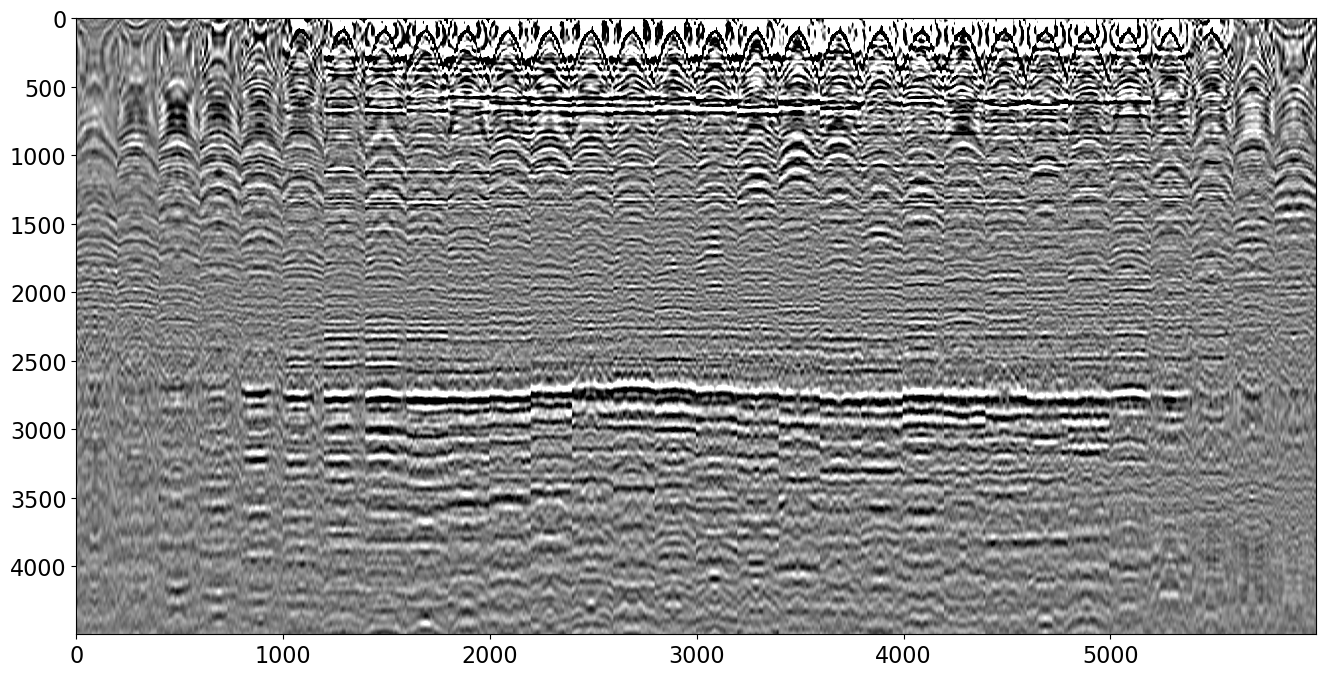

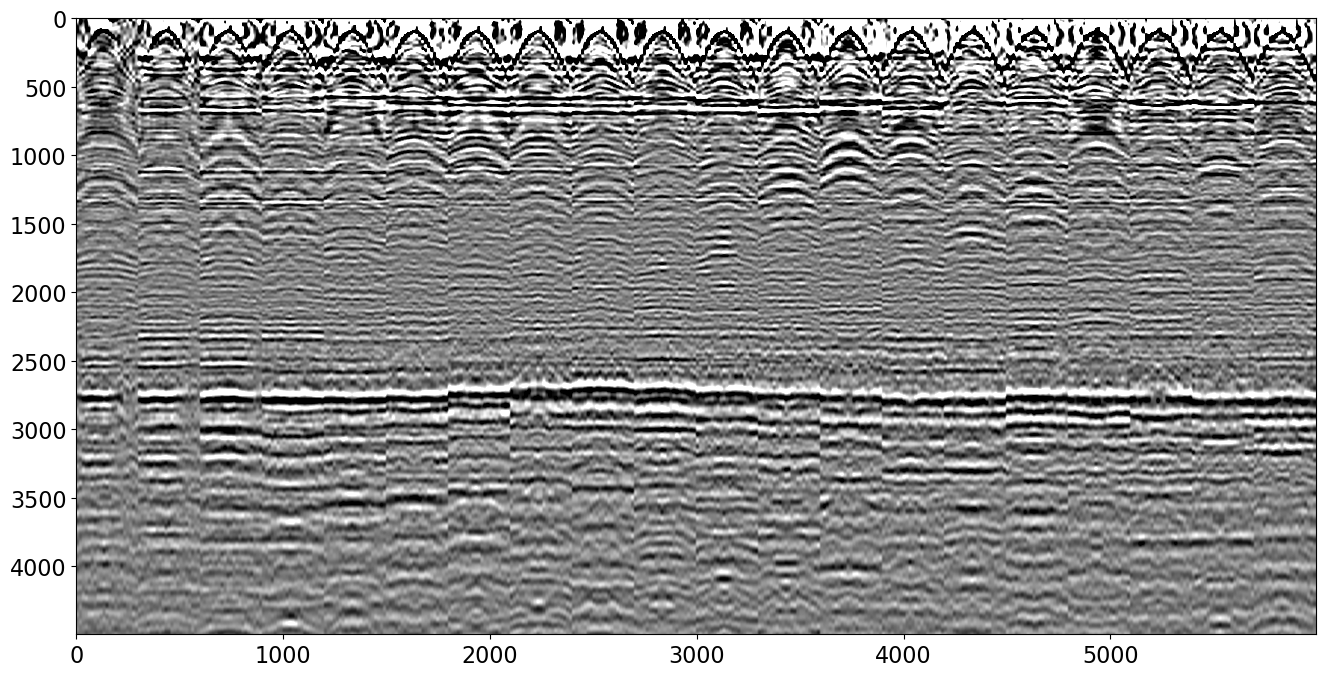

In [25]:
plt.figure(figsize=(16, 8))
plt.imshow(reflmig[:, ::40].transpose(1, 0, 2).reshape(noff*(nx//40), nz).T, cmap='gray', vmin=-1e3, vmax=1e3, 
           extent=(x[0], x[-1], z[-1], z[0]))
plt.axis('tight')

plt.figure(figsize=(16, 8))
plt.imshow(reflmig[:, 200:-200:40].transpose(1, 0, 2).reshape(noff*20, nz).T, cmap='gray', vmin=-1e3, vmax=1e3, 
           extent=(x[0], x[-1], z[-1], z[0]))
plt.axis('tight');